# Cycle Count Report

### R&D by Paul M. Washburn, Operations Analyst

The data comes from [the operations Advantage Dashboard](http://hjiis11/SupplyChainAdvantage/Main.aspx) on the intranet site and from the AS400.  Count data comes directly from Kathie Hinkebein as she sends which counts to Bill Schwein.  

In [41]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from datetime import date
from collections import OrderedDict
import warnings
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 100000)
pd.set_option('display.max_columns', 1000)


path = 'C:/Users/pmwash/Desktop/Re-Engineered Reports/Cycle Counts/'

def simplify_columns(col_list):
    col_list = [str(col).replace(' ', '_').lower() for col in col_list]
    return col_list

def fetch_pw_prd1(path):
    '''
    Fetches product attributes for merging in later
    '''
    df_prd = pd.read_csv(path + 'pw_prd1.csv', encoding='latin1')
    
    # rename columns
    new_cols = {'PPROD#': 'product_number', 'PDESC': 'description', 'PSIZE@': 'size_code',
               'PCLAS@': 'class_code', 'PQTYPC': 'qpc', 'PSUPPL': 'supplier_id', 
               'PBRAN#': 'brand_id', 'PWHSEU': 'x1', 'UPC122': 'x2', 'UPC123': 'x3', 
               'PTYPE': 'type_code', 'PSIZE': 'size'}
    df_prd.rename(columns=new_cols, inplace=True)
    df_prd.drop(['x1', 'x2', 'x3'], axis=1, inplace=True)
    
    return df_prd

def fetch_365_cycle_counts_only(path):
    '''
    Fetches raw data from disk for cycle counts only from intranet/ops dashboard
    '''
    df_counts = pd.read_csv(path + '365_day_cycle_counts_only.csv')
    df_counts.columns = simplify_columns(df_counts.columns)

    df_counts['start_tran_date'] = df_counts['start_tran_date'].apply(pd.to_datetime)
    df_counts['start_tran_time'] = [format(dt.strptime(dat, '%m/%d/%Y %I:%M:%S %p'), '%H:%M:%S') 
                                    for dat in df_counts['start_tran_time'].astype(str)]
    df_counts[['reasoncode', 'lot_number']] = df_counts[['reasoncode', 'lot_number']].fillna('')
    
    # rename product id for merge
    df_counts.rename(columns={'item_number':'product_number'}, inplace=True)

    # add quarter of transaction of count
    df_counts['qtr_counted'] = pd.PeriodIndex(df_counts['start_tran_date'], freq='Q-JAN').strftime('Q%q')
    
    # drop dupes
    df_counts = df_counts.drop_duplicates()
    
    return df_counts

def fetch_finance_count_items(path):
    '''
    Fetches items that Kathie has sent to IT to input for counting.
    '''
    df_products = pd.read_csv(path + 'stl_cycle_count_selections_2017.csv')
    df_products.columns = simplify_columns(df_products.columns)
    
    # change "Y1" to "Q1", etc, from Kathie's data
    qtr_dict = {'Y1': 'Q1', 'Y2': 'Q2', 'Y3': 'Q3', 'Y4': 'Q4'}
    df_products['qtr_count'] = df_products['qtr_count'].map(qtr_dict) 
    df_products.rename(columns={'qtr_count':'qtr_requested'}, inplace=True)
    
    # drop meaningless columns
    df_products = df_products[[col for col in df_products.columns if 'unnamed' not in col]]

    return df_products

# Setup

## Products & Attributes

Create class `Product` that is used to track product-level metrics.  AS400 query is `pw_prd1`.

In [2]:
df_prd = fetch_pw_prd1(path='C:\\Users\\pmwash\\Desktop\\Re-Engineered Reports\\Generalized Lookup Data\\')
df_prd.head()

,product_number,description,size_code,class_code,qpc,supplier_id,brand_id,type_code,size
0,12504,DRAMBUIE 80 W/2 ROCKS GLASSES,39,10,6,266,5001,1,750N
1,13995,MARTELL VSOP COGNAC 80 W/2 SNIFTERS,39,10,6,7,3151,1,750N
2,30004,JIM BEAM OPERATION HOME FRONT,39,10,12,3,1008,1,750*
3,31125,JIM BEAM BLACK 86 W/FLASK,39,10,6,3,1012,1,750N*
4,81402,CHIVAS REGAL 12YR W/DECANTER,22,10,3,7,480,1,175N


### Make Objects for `Product`s

Saving `Product`s to the dictionary `product_obj_dict` by product number.

In [17]:
class Product(object):
    def __init__(self, product_number, description, size_code, qpc, supplier_id, brand_id):
        self.product_number = product_number
        self.description = description
        self.size_code = size_code
        self.qpc = qpc
        self.supplier_id = supplier_id
        self.brand_id = brand_id
        self.times_counted = 0
        self.counts = []
        
    def __str__(self):
        return '''
        Product:             %s  -  %s
        Supplier:            %s
        Counts for Product:  %s
        ''' %(self.product_number, self.description, 
              self.supplier_id,
              self.times_counted)
        
    def count_product(self, CycleCount):
        try:
            if CycleCount.cycle_count_id not in [count.cycle_count_id for count in self.counts]:
                self.counts.append(CycleCount)
                self.times_counted += 1
        except:
            pass

# instantiate Product objects in list
product_obj_dict = {}
for i, prod_id in enumerate(df_prd['product_number'].tolist()): #already unique bc from PRD1
    product_obj_dict[prod_id] = Product(prod_id, 
                                        df_prd.loc[i, 'description'],
                                        df_prd.loc[i, 'size_code'],
                                        df_prd.loc[i, 'qpc'], 
                                        df_prd.loc[i, 'supplier_id'],
                                        df_prd.loc[i, 'brand_id'])

## Employees That Perform Cycle Counts

In [18]:
class EmployeeCounter(object):
    def __init__(self, employee_id):
        self.employee_id = employee_id
        self.number_counts = 0
        self.counts = []
        
    def __str__(self):
        return '''
        Employee:  %s  
        Number of Counts:  %s
        ''' %(self.employee_id, self.number_counts)

    def log_count(self, CycleCount):
        try:
            if CycleCount.cycle_count_id not in [count.cycle_count_id for count in self.counts]:
                self.counts.append(CycleCount)
                self.number_counts += 1
        except: pass
        
    def fetch_employee_counts(self):
        if len(self.counts) > 0:
            emp_count_data = []
            for i, count in enumerate(self.counts):
                dat = count.date_counted
                emp_count_data.append({'date_counted':dat, 
                                       'product_number': count.product.product_number, 
                                       'description': count.product.description,
                                       'time_counted': count.time_counted, 
                                       'qty_counted': count.qty_counted, 
                                       'qty_adjusted': count.qty_adjusted, 
                                       'reason_code': count.reason_code,
                                       'tran_type': count.tran_type, 
                                       'employee_id': self.employee_id})
            df = pd.DataFrame(emp_count_data)
            df['month'] = format(dat, '%B')
            df['week'] = format(dat, '%U')
            df['weekday'] = format(dat, '%a')
            df['date_counted'] = format(dat, '%Y-%m-%d')
        else: 
            df = pd.DataFrame()
        
        return df

## 365 Day Cycle Counts for STL from Intranet Operations Dashboard

### Make Objects for `EmployeeCounter`s from 365 Day Cycle Counts Only

In [19]:
# read in counts to get employee data
df_counts = fetch_365_cycle_counts_only(path)

employee_counters_dict = {}
for i, emp in enumerate(df_counts['employee_id'].unique().tolist()):
    employee_counters_dict[emp] = EmployeeCounter(emp)
    print(employee_counters_dict[emp])


        Employee:  AMHART  
        Number of Counts:  0
        

        Employee:  BMSCHR  
        Number of Counts:  0
        

        Employee:  CLEVAN  
        Number of Counts:  0
        

        Employee:  BRBAUE  
        Number of Counts:  0
        

        Employee:  BPKLOE  
        Number of Counts:  0
        

        Employee:  MSSICK  
        Number of Counts:  0
        

        Employee:  TMRADE  
        Number of Counts:  0
        

        Employee:  AGNEWS  
        Number of Counts:  0
        

        Employee:  ESHORC  
        Number of Counts:  0
        

        Employee:  DCHERC  
        Number of Counts:  0
        

        Employee:  WFS  
        Number of Counts:  0
        

        Employee:  JMBEHR  
        Number of Counts:  0
        


In [20]:
df_counts.head()

,tran_type,description,start_tran_date,start_tran_time,employee_id,location_id,num_items,product_number,lot_number,adj_amt,reasoncode,qtr_counted
0,800,Cycle Count,2016-12-19,14:27:51,AMHART,H713D,48,2513074,,0,,Q4
1,800,Cycle Count,2016-12-19,14:43:19,AMHART,C099A,576,2361527,,0,,Q4
2,800,Cycle Count,2016-12-19,14:43:44,AMHART,C147A,108,3545122,,0,,Q4
3,800,Cycle Count,2016-12-19,14:43:55,AMHART,C148C,714,3545122,,6,,Q4
4,800,Cycle Count,2016-12-19,14:44:11,AMHART,C149A,72,770042,,-6,,Q4


## Create `CycleCount` Data Structure

In [69]:
class CycleCount(object):
    def __init__(self, Product, 
                 date_counted, 
                 time_counted, 
                 EmployeeCounter, 
                 location_id, 
                 tran_type, 
                 reason_code, 
                 qty_counted, 
                 qty_adjusted):
        self.cycle_count_id = str(date_counted).replace(' ', '')+'_'+str(EmployeeCounter.employee_id).lower()+'_'+str(Product.product_number)
        self.product = Product
        self.date_counted = format(date_counted, '%Y-%m-%d')
        self.weekday_counted = format(date_counted, '%a')
        self.time_counted = time_counted
        self.employee = EmployeeCounter
        self.location_id = location_id
        self.tran_type = tran_type
        self.reason_code = reason_code
        self.qty_counted = qty_counted
        self.qty_adjusted = qty_adjusted
        
    def __str__(self):
        return '''
        Date:          %s  
        Product:       %s  -  %s  
        Employee:      %s  
        Qty Adjusted:  %s
        ''' %(self.date_counted, 
              self.product.product_number, self.product.description, 
              self.employee.employee_id,
              self.qty_adjusted)
    
    def count_info(self):
        count_info = self.__dict__
        count_info.update({'product_number': self.product.product_number, 
                           'product_name': self.product.description,
                           'product_times_counted': self.product.times_counted,
                           'employee_id': self.employee.employee_id,
                           'weekday_counted': self.weekday_counted})
        
        return count_info

### Instantiate `CycleCount`, and To Them Assign `EmployeeCounter` Who Counted It

This file contains a year's worth of `CycleCount`s.  It comes from the intranet's Operations Dashboard.  Below, `CycleCount` objects are created and data is extracted from these objects and stored in a `pd.DataFrame` object for data analysis.

In [70]:
# instantiate CycleCount objects in list
cycle_counts, cycle_counts_df = [], pd.DataFrame()
for i, prod_id in enumerate(df_counts['product_number'].tolist()):
    emp_id = df_counts.loc[i, 'employee_id']
    cycle_count_obj = CycleCount(product_obj_dict[prod_id],
                                 df_counts.loc[i, 'start_tran_date'],
                                 df_counts.loc[i, 'start_tran_time'],
                                 employee_counters_dict[emp_id],
                                 df_counts.loc[i, 'location_id'],
                                 df_counts.loc[i, 'tran_type'],
                                 df_counts.loc[i, 'reasoncode'],
                                 df_counts.loc[i, 'num_items'],
                                 df_counts.loc[i, 'adj_amt'])
    cycle_counts.append(cycle_count_obj)
    
    # get data for cycle count analysis
    cycle_counts_df = cycle_counts_df.append(pd.DataFrame([cycle_count_obj.count_info()]))
    
    # account for the cycle count at Product level
    product_obj_dict[prod_id].count_product(cycle_count_obj)
    
    # account for the cycle count at the EmployeeCounter level
    employee_counters_dict[emp_id].log_count(cycle_count_obj)

cycle_counts_df.set_index('cycle_count_id', inplace=True)
cycle_counts_df.drop(columns=['employee', 'product'], inplace=True)

cycle_counts_df.head()

,date_counted,employee_id,location_id,product_name,product_number,product_times_counted,qty_adjusted,qty_counted,reason_code,time_counted,tran_type,weekday_counted
cycle_count_id,,,,,,,,,,,,
2016-12-1900:00:00_amhart_2513074,2016-12-19,AMHART,H713D,OZEKI SAKE,2513074,1,0,48,,14:27:51,800,Mon
2016-12-1900:00:00_amhart_2361527,2016-12-19,AMHART,C099A,OAK LEAF CHARD ECO PAK,2361527,7,0,576,,14:43:19,800,Mon
2016-12-1900:00:00_amhart_3545122,2016-12-19,AMHART,C147A,CUERVO GOLD 80,3545122,10,0,108,,14:43:44,800,Mon
2016-12-1900:00:00_amhart_3545122,2016-12-19,AMHART,C148C,CUERVO GOLD 80,3545122,10,6,714,,14:43:55,800,Mon
2016-12-1900:00:00_amhart_770042,2016-12-19,AMHART,C149A,MALIBU COCONUT RUM,770042,14,-6,72,,14:44:11,800,Mon


### Quick Description of Cycle Counts Only

,,product_times_counted,qty_counted,qty_adjusted,abs_pct_adjusted
product_number,product_name,,,,
140679,ABSOLUT 50ML TRIAL PACK,2,17760.00,0.00,0.00
4014004,CRISPIN MIXOLOGY CUPS 32Z (300),1,17700.00,0.00,0.00
2830211,RED BULL LOOSE CANS 1718,8,17287.20,60.00,0.00
740199,ABSOLUT LIME VODKA,3,15736.00,4.00,0.00
310089,JIM BEAM 4 80 10/SLV,10,14513.27,-16.00,0.00
2830311,RED BULL SF LOOSE CANS 2746,3,13770.00,0.00,0.00
2830224,RED BULL CLUB PACK 35263,8,13090.67,101.33,0.01
406009,HARTLEY BRANDY 12/SLV,3,12640.00,0.00,0.00
2830324,RED BULL SF CLUB PACK 36460,1,12360.00,96.00,0.01


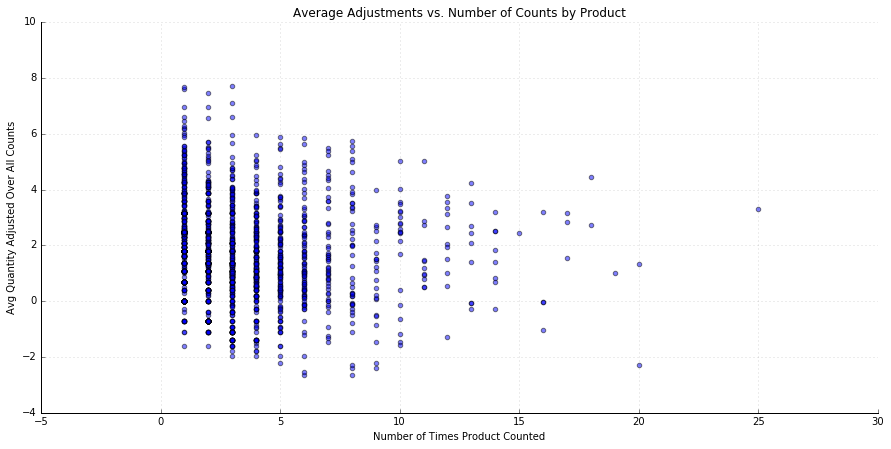

In [102]:
import seaborn as sns

agg_funcs = {'product_times_counted': np.max, 
             'qty_adjusted': np.mean,
             'qty_counted': np.mean}

cycle_count_summary = cycle_counts_df.groupby(['product_number', 'product_name']).agg(agg_funcs)
cycle_count_summary['abs_pct_adjusted'] = np.divide(cycle_count_summary['qty_adjusted'].abs(), 
                                                    cycle_count_summary['qty_counted'])
cycle_count_summary = cycle_count_summary.sort_values('qty_counted', ascending=False) #qty_counted
cycle_count_summary = cycle_count_summary[['product_times_counted', 'qty_counted', 'qty_adjusted', 'abs_pct_adjusted']]
cycle_count_summary = cycle_count_summary.apply(lambda x: round(x, 2))

fig, ax = plt.subplots(figsize=(15, 7))
ax.scatter(cycle_count_summary['product_times_counted'], np.log(cycle_count_summary['qty_adjusted'].abs()), alpha=0.5)
ax.set_xlabel('Number of Times Product Counted')
ax.set_ylabel('Avg Quantity Adjusted Over All Counts')
ax.grid(alpha=0.3)
ax.set_title('Average Adjustments vs. Number of Counts by Product')
#plt.set_style('seaborn-whitegrid')
sns.despine()

cycle_count_summary.head(25)

In [75]:
agg_funcs = {'qty_adjusted': np.mean,
             'qty_counted': np.mean}

cycle_count_summary = cycle_counts_df.groupby(['employee_id']).agg(agg_funcs)
cycle_count_summary['abs_pct_adjusted'] = np.divide(cycle_count_summary['qty_adjusted'].abs(), 
                                                    cycle_count_summary['qty_counted'])
cycle_count_summary = cycle_count_summary.sort_values('qty_counted', ascending=False) #qty_counted
cycle_count_summary = cycle_count_summary[['qty_counted', 'qty_adjusted', 'abs_pct_adjusted']]
cycle_count_summary = cycle_count_summary.apply(lambda x: round(x, 2))

cycle_count_summary

,qty_counted,qty_adjusted,abs_pct_adjusted
employee_id,,,
JMBEHR,1840.41,-16.61,0.01
AMHART,757.89,2.82,0.00
BMSCHR,490.47,-0.39,0.00
CLEVAN,283.34,-0.57,0.00
WFS,250.00,0.00,0.00
MSSICK,113.82,-0.89,0.01
DCHERC,111.76,4.00,0.04
BPKLOE,101.62,-1.39,0.01
ESHORC,100.38,1.33,0.01


,,qty_counted,qty_adjusted,abs_pct_adjusted
date_counted,weekday_counted,,,
2017-12-15,Fri,1161.18,-1.97,0.000000
2017-12-14,Thu,1360.75,15.85,0.010000
2017-12-13,Wed,427.34,4.56,0.010000
2017-12-12,Tue,844.35,-3.24,0.000000
2017-12-11,Mon,1562.60,9.73,0.010000
2017-12-08,Fri,732.79,6.37,0.010000
2017-12-07,Thu,141.06,-1.72,0.010000
2017-12-06,Wed,130.39,-0.82,0.010000
2017-12-05,Tue,1100.70,-1.01,0.000000


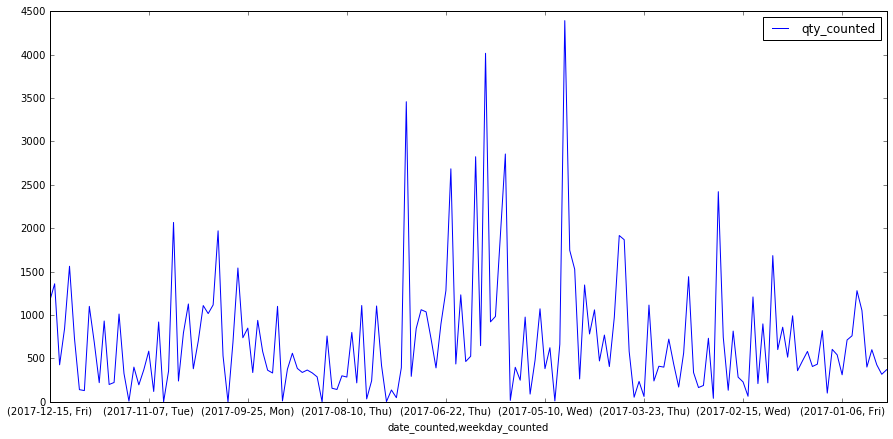

In [107]:
agg_funcs = {'qty_adjusted': np.mean,
             'qty_counted': np.mean}

cycle_count_summary = cycle_counts_df.groupby(['date_counted', 'weekday_counted']).agg(agg_funcs)
cycle_count_summary['abs_pct_adjusted'] = np.divide(cycle_count_summary['qty_adjusted'].abs(), 
                                                    cycle_count_summary['qty_counted'])
cycle_count_summary = cycle_count_summary.sort_values('qty_counted', ascending=False) #qty_counted
cycle_count_summary = cycle_count_summary[['qty_counted', 'qty_adjusted', 'abs_pct_adjusted']]
cycle_count_summary = cycle_count_summary.apply(lambda x: round(x, 2))
cycle_count_summary.sort_index(inplace=True, ascending=False)

cycle_count_summary[['qty_counted']].plot(figsize=(15, 7))
cycle_count_summary

## Cycle Count Selections from Finance

Supplied by Kathie Hinkebein.

In [81]:
df_finance = fetch_finance_count_items(path)
df_finance.head()

,company,product_number,priority,qtr_requested
0,2,2830211,2,Q1
1,2,310084,2,Q1
2,2,371014,2,Q1
3,2,371013,2,Q1
4,2,3545124,2,Q1


## Create `FinancePlannedCycleCount` Data Structure

In [82]:
class FinancePlannedCycleCount(object):
    def __init__(self, company, qtr_requested, Product, priority):
        '''
        FinancePlannedCycleCount takes as input parameters data from Kathie
        Hinkebein's list of products supplied to Bill Schwein in IT dept
        for input as CycleCounts to be done.  These then are entered into 
        HighJump to schedule the CycleCount. 
        
        Instantiate with:
        --------------------------------------------------
         company: {1: KC, 2: STL}
         qtr_requested: 
         Product:
         priority:
        '''
        self.company = company
        self.qtr_requested = qtr_requested
        self.product = Product
        self.priority = priority
        if len(Product.counts) > 0: 
            self.executed = True
            self.associated_counts = Product.counts
        else:
            self.associated_counts = []
            self.executed = False
        
    def __str__(self):
        [print(count) for count in self.product.counts if len(self.product.counts) > 0]
        
        return '''
        Product:          %s  -  %s  
        Qtr:              %s  
        Priority:         %s
        Count Completed:  %s
        ''' %(self.product.product_number, self.product.description, 
              self.qtr_requested,
              self.priority, 
              self.executed)
    
    def fetch_finance_counts(self):
        if self.executed:
            fin_count_data = []
            for count in self.associated_counts:
                dat = {'date_counted': count.date_counted,
                      'employee_id': count.employee.employee_id,
                      'product_number': count.product.product_number,
                      'product_name': count.product.description,
                      'qty_counted': count.qty_counted,
                      'qty_adjusted': count.qty_adjusted, 
                      'tran_type': count.tran_type}
                fin_count_data.append(dat)
            
            df = pd.DataFrame(fin_count_data)

            df['qtr_requested'] = self.qtr_requested
            df['executed'] = self.executed
            
        else:
            dat = [{'date_counted': None,
                    'employee_id': None,
                    'product_number': self.product.product_number,
                    'product_name': self.product.description,
                    'qty_counted': None,
                    'qty_adjusted': None, 
                    'tran_type': None}]
            df = pd.DataFrame(dat)

            df['qtr_requested'] = self.qtr_requested
            df['executed'] = self.executed
            
        return df

### Instantiate `FinancePlannedCycleCount` Objects

In [86]:
# instantiate FinanceCycleCount objects in list
finance_cycle_counts, finance_cycle_counts_df = [], pd.DataFrame()
for i, prod_id in enumerate(df_finance['product_number'].tolist()):
    planned_count_obj = FinancePlannedCycleCount(df_finance.loc[i, 'company'],
                                            df_finance.loc[i, 'qtr_requested'],
                                            product_obj_dict[prod_id], 
                                            df_finance.loc[i, 'priority'])
    finance_cycle_counts.append(planned_count_obj)
    finance_cycle_counts_df = finance_cycle_counts_df.append(planned_count_obj.fetch_finance_counts())
    
finance_cycle_counts_df.head()

,date_counted,employee_id,product_name,product_number,qty_adjusted,qty_counted,tran_type,qtr_requested,executed
0,2017-06-29 00:00:00,AMHART,RED BULL LOOSE CANS 1718,2830211,0,5496,800,Q1,True
1,2017-07-06 00:00:00,AMHART,RED BULL LOOSE CANS 1718,2830211,0,2448,800,Q1,True
2,2017-07-12 00:00:00,AMHART,RED BULL LOOSE CANS 1718,2830211,0,4416,800,Q1,True
3,2017-09-27 00:00:00,JMBEHR,RED BULL LOOSE CANS 1718,2830211,600,4440,800,Q1,True
4,2017-09-27 00:00:00,AMHART,RED BULL LOOSE CANS 1718,2830211,0,20736,800,Q1,True


In [88]:
finance_cycle_counts_df.loc[finance_cycle_counts_df.executed == False]

,date_counted,employee_id,product_name,product_number,qty_adjusted,qty_counted,tran_type,qtr_requested,executed
0,None,None,CUERVO GOLD 80 TRAY PACK,3545119,None,None,None,Q1,False
0,None,None,JIM BEAM W/100ML JB APPLE,310094,None,None,None,Q1,False
0,None,None,LOLAILO SANGRIA TRAY PACK,1342802,None,None,None,Q1,False
0,None,None,AVERY TWEAK 12Z LOOSE,3461316,None,None,None,Q1,False
0,None,None,BLACKSTONE P NOIR CAL,1480104,None,None,None,Q1,False
0,None,None,MACALLAN GOLD,1395224,None,None,None,Q1,False
0,None,None,TALLGRASS VAN BEAN BUFFALO SWEAT 6/4,2601146,None,None,None,Q1,False
0,None,None,KIRKLAND SIGNATURE BLND SCOTCH 12YR,1544952,None,None,None,Q1,False
0,None,None,GREEN FLASH WEST COAST IPA 4/6PK,5251026,None,None,None,Q1,False
0,None,None,ACE PINEAPPLE CIDER,1971031,None,None,None,Q1,False


## Map In Proxy Starting Date for Cycle Count Request for Each Item

A "starting date" for each count is assumed to be the first day of each quarter.

In [ ]:
def date_count_requested(qtr_count, start_tran_date):
    '''
    Uses quarter and transaction date to retroactively map to the beginning of that quarter.
    
    Note: ask Kathie to start putting in year if always rolling 365
    '''
    year_now = dt.now().year
    start_tran_year = start_tran_date.year
    year_to_use = min(year_now, start_tran_year)
    
    start_tran_month = start_tran_date.month
    if int(start_tran_month) in [1, 2, 3]:
        start_tran_year = year_to_use - 1
    
    if qtr_count == 'Q4':
        dat = pd.to_datetime(str(year_to_use) + '/10/01')
    elif qtr_count == 'Q3':
        dat = pd.to_datetime(str(year_to_use) + '/07/01')
    elif qtr_count == 'Q2':
        dat = pd.to_datetime(str(year_to_use) + '/04/01')
    else:
        dat = pd.to_datetime(str(year_to_use) + '/01/01')
    
    return dat
    
# map date to quarters to get proxy for requested date
df['count_requested_date']  = [date_count_requested(qtr, start) for qtr,start in zip(df['qtr_counted'], df['start_tran_date'])]
df['days_requested_to_count'] = df['start_tran_date'] - df['count_requested_date']

view_cols = ['product_number', 'start_tran_date', 'count_requested_date', 'days_requested_to_count', 'qtr_counted', 'qtr_requested']

df[view_cols]

In [ ]:
df.loc[df.days_requested_to_count < pd.Timedelta('0 days'), view_cols]

## 365 Day - All Adjustments

In [ ]:
def fetch_365_all_adjustments(path):
    '''
    Fetches all adjustment data from operations dashboard
    '''
    df_adjustments = pd.read_csv(path + '365_day_all_adjustments.csv')
    df_adjustments.columns = simplify_columns(df_adjustments.columns)

    df_adjustments['start_tran_date'] = df_adjustments['start_tran_date'].apply(pd.to_datetime)
    df_adjustments['start_tran_time'] = [format(dt.strptime(dat, '%m/%d/%Y %I:%M:%S %p'), '%H:%M:%S') 
                                    for dat in df_adjustments['start_tran_time'].astype(str)]

    df_adjustments[['reasoncode', 'lot_number']] = df_adjustments[['reasoncode', 'lot_number']].fillna('')
    
    return df_adjustments
    
df_adjustments = fetch_365_all_adjustments(path)    
df_adjustments.head()

In [ ]:
df = df_adjustments.merge(df_products, on='')

## AS400 Finance Cycle Count Report

In [ ]:
df_as400 = pd.read_csv(path + 'as400_finance_cycle_count_report.csv', encoding='latin_1')
df_as400.columns = simplify_columns(df_as400.columns)
df_as400.head()

In [ ]:
print(df.head())

In [ ]:
df_as400 = pd.read_csv(path + 'AS400 Finance Cycle Count Report.csv', encoding='latin_1')

df = df_counts.merge(df_products, left_on='Item Number', right_on='Product Number', how='left')

df.head()

In [ ]:
df_as400.head()

In [ ]:
df_products.head()

In [ ]:
?pd.read_csv